In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 32

train_dataloader = DataLoader(
    dataset=training_data,
    batch_size=batch_size,
)
test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=batch_size,
)
print(f"type of test_dataloader: {type(test_dataloader)}")

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

device = (
    torch.accelerator.current_accelerator().type
    if torch.accelerator.is_available()
    else "cpu"
)
print(f"Using {device} device")


# define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device=device)
# print("Neural Network: ", model)
# print("model parameters: ", model.parameters())
for parameters in model.parameters():
    print("parameter shape: ", parameters.shape)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    print(f"size: {size}")
    model.train(mode=True)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        # print("input shape ", X.shape, y.shape, batch)
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # print(pred.shape)
        # print(loss)
        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            loss = loss.item()
            current = (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(test_dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_dataloader:
            X, y = X.to(device=device), y.to(device=device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        print(
            f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
        )


epoch = 5
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train(
        data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
    )
    test(
        dataloader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
    )
print("Done!")

type of test_dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64
Using cpu device
parameter shape:  torch.Size([512, 784])
parameter shape:  torch.Size([512])
parameter shape:  torch.Size([512, 512])
parameter shape:  torch.Size([512])
parameter shape:  torch.Size([10, 512])
parameter shape:  torch.Size([10])
Epoch 1
-------------------------------
size: 60000
loss: 2.309996  [   32/60000]
loss: 2.283347  [ 3232/60000]
loss: 2.293590  [ 6432/60000]
loss: 2.259240  [ 9632/60000]
loss: 2.253969  [12832/60000]
loss: 2.230578  [16032/60000]
loss: 2.206032  [19232/60000]
loss: 2.202056  [22432/60000]
loss: 2.210904  [25632/60000]
loss: 2.151429  [28832/60000]
loss: 2.098078  [32032/60000]
loss: 2.063769  [35232/60000]
loss: 2.153955  [38432/60000]
loss: 2.059959  [41632/60000]
loss: 2.008172  [44832/60000]
loss: 1.996480  [48032/60000]
loss: 2.068512  [51232/60000]
loss: 1.973129  [54432/6

In [5]:
params = model.state_dict()

In [7]:
type(params)

collections.OrderedDict

In [9]:
for data in params.values():
    print(data.shape)

torch.Size([512, 784])
torch.Size([512])
torch.Size([512, 512])
torch.Size([512])
torch.Size([10, 512])
torch.Size([10])


In [10]:
torch.save(model.state_dict(), "model.pth")

In [11]:
model = NeuralNetwork().to(device=device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

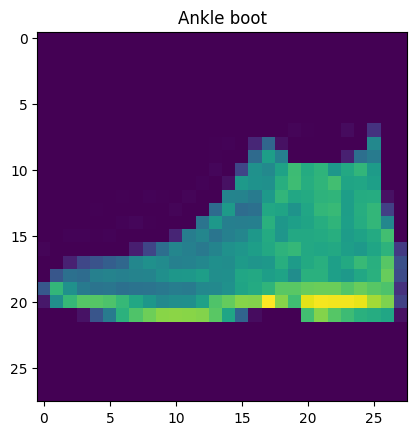

In [32]:
import matplotlib.pyplot as plt


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
model.eval()
x,y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x).squeeze().argmax(axis=0)
    predicted_label, actual_label = classes[pred], classes[y]
    plt.imshow(x.squeeze())
    plt.title(predicted_label)


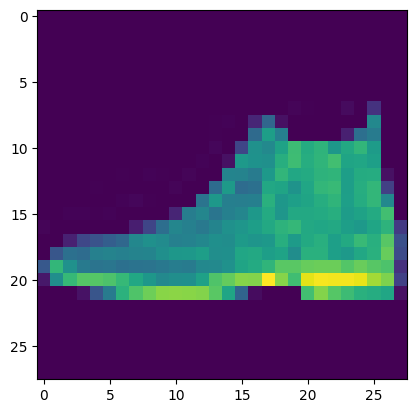